# Method :  Synthetic signal analysis (slow and fast components)

In [1]:
import numpy as np
from scipy.signal import hilbert
import xarray as xr
import statsmodels.api as sm
import scipy.ndimage as im
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal
import sstats.tseries as ts

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()

#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=1)

client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:52270 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


## Generating data + plot 

In [3]:
Tw = 500
Nw = 50
Tl = 10

In [4]:
def exp_autocorr(name):
    x = (ts.exp_autocorr((Tw, 1./24), 
                         [Tl for _ in range(Nw)], 
                         1, 
                         draws=100, 
                         name=name
                        )
         .rename({'tau':'windows'})
         .assign_coords(windows=np.arange(Nw))
        )
    return x

### Generating fast component : modulated fast oscillations

In [5]:
xtilde = exp_autocorr('xt').persist()
ytilde = exp_autocorr('yt').persist()

In [6]:
omega = 2*np.pi*2

#ztilde = np.real((0.+xtilde)*np.cos(omega*xtilde.time)+1j*ytilde*np.sin(omega*xtilde.time)).rename('ztilde')#.persist()
ztilde = (np.real((0.+xtilde+1j*ytilde)
                 *np.exp(1j*omega*xtilde.time)
                )
          .rename('ztilde')
         )#.persist()

#zhtilde = xr.apply_ufunc(hilbert, ztilde, dask='parallelized', output_dtypes=[complex])

#Rtilde = np.abs(zhtilde)
#thetatilde = np.angle(zhtilde)

In [7]:
ztilde

<xarray.DataArray 'ztilde' (windows: 50, draw: 100, time: 12000)>
dask.array<real, shape=(50, 100, 12000), dtype=float64, chunksize=(25, 25, 12000), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0

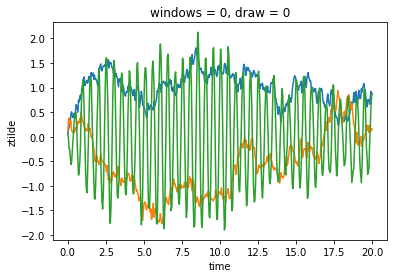

In [8]:
#ztilde.sel(draw=0).sel(time=slice(0,50)).mean('windows').plot()
xtilde.sel(draw=0,time=slice(0,20),windows=0).plot()
ytilde.sel(draw=0,time=slice(0,20),windows=0).plot()
ztilde.sel(draw=0,time=slice(0,20),windows=0).plot()
#ytilde.sel(draw=0).sel(time=slice(0,20)).isel(windows=0).plot()
#ztilde.sel(draw=0).sel(time=slice(0,20)).isel(windows=0).plot()

### Generating slow component : exponentially correlated time series

In [9]:
xbar = exp_autocorr('xb').persist()

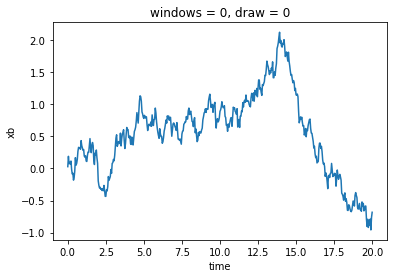

In [10]:
xbar.sel(draw=0,time=slice(0,20),windows=0).plot()

## Superposition : total signal 

In [11]:
xtotal = xbar + ztilde
#xtotal.name = 'xtot0'
#xtotal = xtotal.persist()

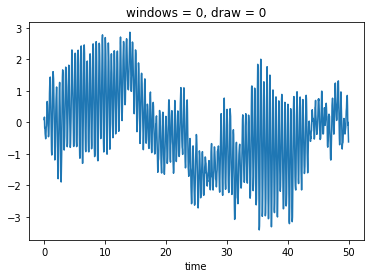

In [12]:
xtotal.sel(draw=0,time=slice(0,50),windows=0).plot()

## Filter

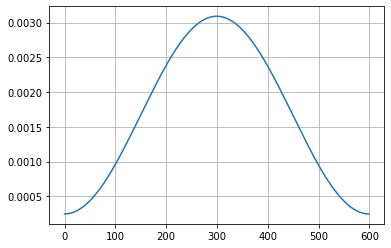

In [25]:
dt = (xtotal.time[1]-xtotal.time[0])
Nh = 24*25
h = signal.firwin(Nh, cutoff=[1./(2.*24*3600)], pass_zero=True, fs=1./2/dt, scale=True)

ax = plt.subplot(111)
ax.plot(h)
ax.grid()

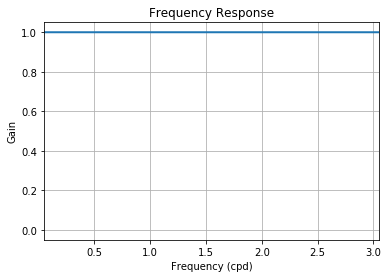

In [26]:
w, hh = signal.freqz(h, worN=8000)
plt.plot((w/np.pi)/2/dt.values*3600*24, abs(hh), linewidth=2)
plt.xlabel('Frequency (cpd)')
plt.ylabel('Gain')
plt.title('Frequency Response')
plt.ylim(-0.05, 1.05)
plt.xlim(0.05, 3.05)
plt.grid(True)

In [27]:
def conv(x, t, omega):
    ''' omega is in cpd
    '''
    if omega>0:
        return im.convolve1d(x * np.cos(2.*np.pi*omega*t), h, mode='constant') \
                + 1j * im.convolve1d(x * np.sin(2.*np.pi*omega*t), h, mode='constant')
    else:
        lx = x
        return im.convolve1d(lx, h, mode='constant')

def filt(v, omega=0, rechunk=True):
    v = v.chunk({'time': len(v.time)})
    return xr.apply_ufunc(conv, v, v.time, omega, 
                    dask='parallelized', output_dtypes=[np.complex64],
                    input_core_dims=[['time'],['time'],[]],
                    output_core_dims=[['time']],
                    output_sizes={'time': len(v.time)})

In [28]:
it = slice(0,50)
lds = xtotal.sel(time=it)

In [29]:
v_low = filt(lds)
v_2 = filt(lds, omega=2.)
print(v_low)

<xarray.DataArray (windows: 50, draw: 100, time: 1201)>
dask.array<conv, shape=(50, 100, 1201), dtype=complex64, chunksize=(25, 25, 1201), chunktype=numpy.ndarray>
Coordinates:
  * windows  (windows) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 49.88 49.92 49.96 50.0


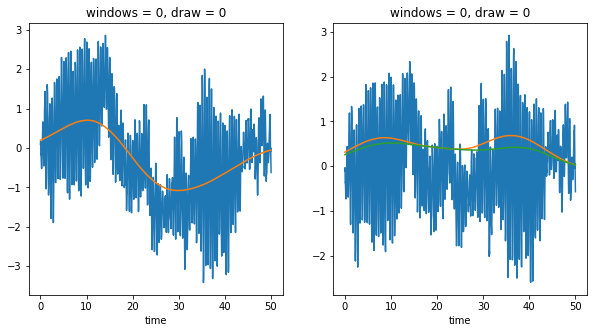

In [30]:
fig = plt.figure(figsize=(10,5))
#
ax = plt.subplot(121)
lds.sel(draw=0,windows=0).plot(ax=ax)
v_low.sel(draw=0,windows=0).plot(ax=ax)

ax = plt.subplot(122)
(lds.sel(draw=0,windows=0) - v_low.sel(draw=0,windows=0)).plot(ax=ax)
np.abs(v_2.sel(draw=0,windows=0)).plot(ax=ax)
np.real(v_2.sel(draw=0,windows=0)).plot(ax=ax)

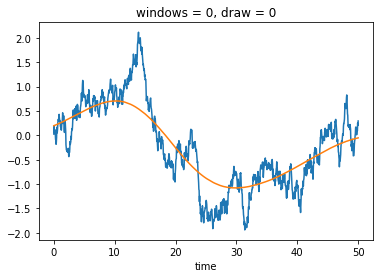

In [35]:
xbar.sel(time=it).sel(draw=0,windows=0).plot()
v_low.sel(draw=0,windows=0).plot()

In [46]:
xxbar = ts.correlate(xbar.sel(time=it),xbar.sel(time=it),detrend=False).persist()

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-734066e369b3d9631a009f2786f3540f', 0)": ['tcp://127.0.0.1:37046']} state: ['memory'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:37046'], ('getitem-734066e369b3d9631a009f2786f3540f', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-734066e369b3d9631a009f2786f3540f', 0)": ('tcp://127.0.0.1:37046',)}
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-734066e369b3d9631a009f2786f3540f', 0)": ['tcp://127.0.0.1:37046']} state: ['memory'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:37046'], ('getitem-734066e369b3d9631a009f2786f3540f', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-734066e369b3d9631a009f2786f3540f', 0)": ('tcp://127.0.0.1:37046',)}
distributed.scheduler - ERROR - Couldn't

In [43]:
v_low.name = 'low_filter'

In [44]:
vv_low = ts.correlate(v_low,v_low,detrend=False)

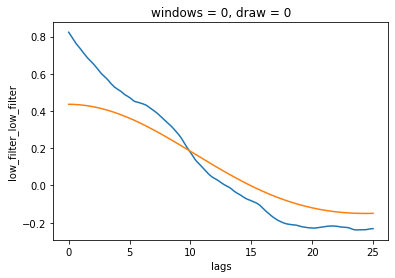

In [47]:
xxbar.sel(draw=0,windows=0).plot()
vv_low.sel(draw=0,windows=0).plot()

## Hilbert transform

In [ ]:
#fast comp
zhtilde = xr.apply_ufunc(hilbert, ztilde, dask='parallelized', output_dtypes=[complex]).rename('zhtilde')

Rtilde = np.abs(zhtilde)
thetatilde = np.angle(zhtilde)

In [ ]:
xxh = ts.correlate(np.imag(zhtilde),np.imag(zhtilde),detrend=False).persist()

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xxh.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xxh.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xxh.mean(['draw','windows']).plot(ax=ax[1,0])
#xxh.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
fig.delaxes(axes[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid()#;ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
#ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

### Fast component : autocorrelation

In [5]:
xx = ts.correlate(ztilde,ztilde,detrend=False).persist()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Zoom mean : lags$\\in$[50;250]')

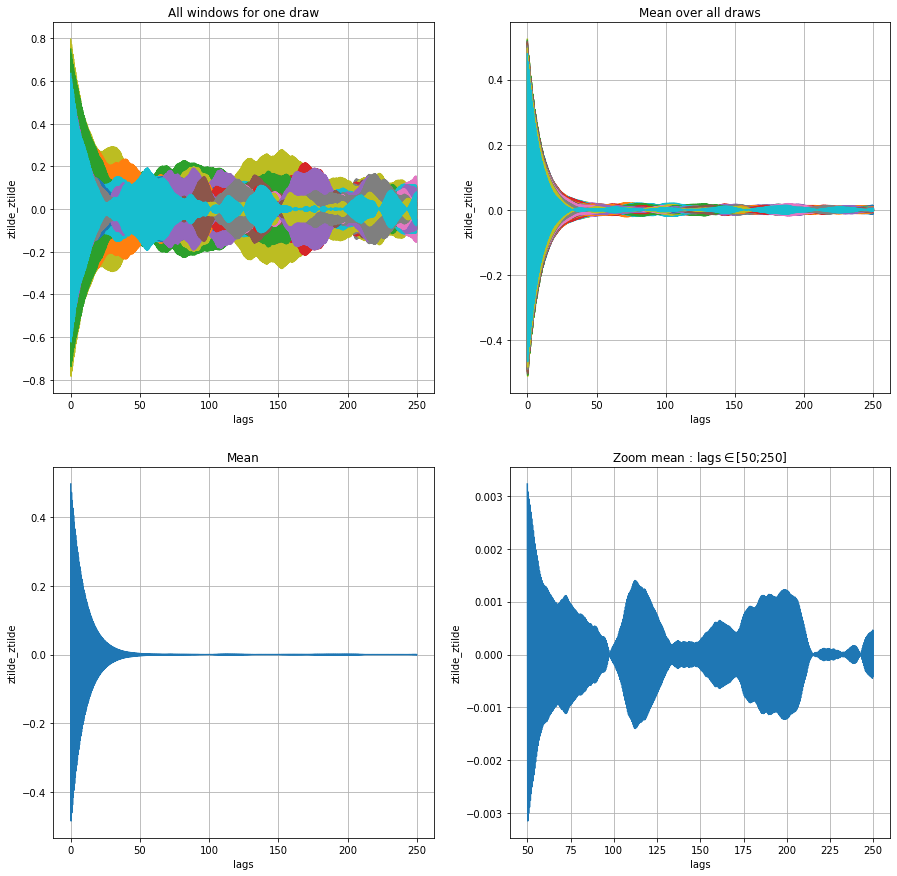

In [25]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xx.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xx.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xx.mean(['draw','windows']).plot(ax=ax[1,0])
xx.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid();ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

### Slow component : autocorrelation

In [12]:
xxbar = ts.correlate(xbar,xbar,detrend=False).persist()

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Zoom mean : lags$\\in$[50;250]')

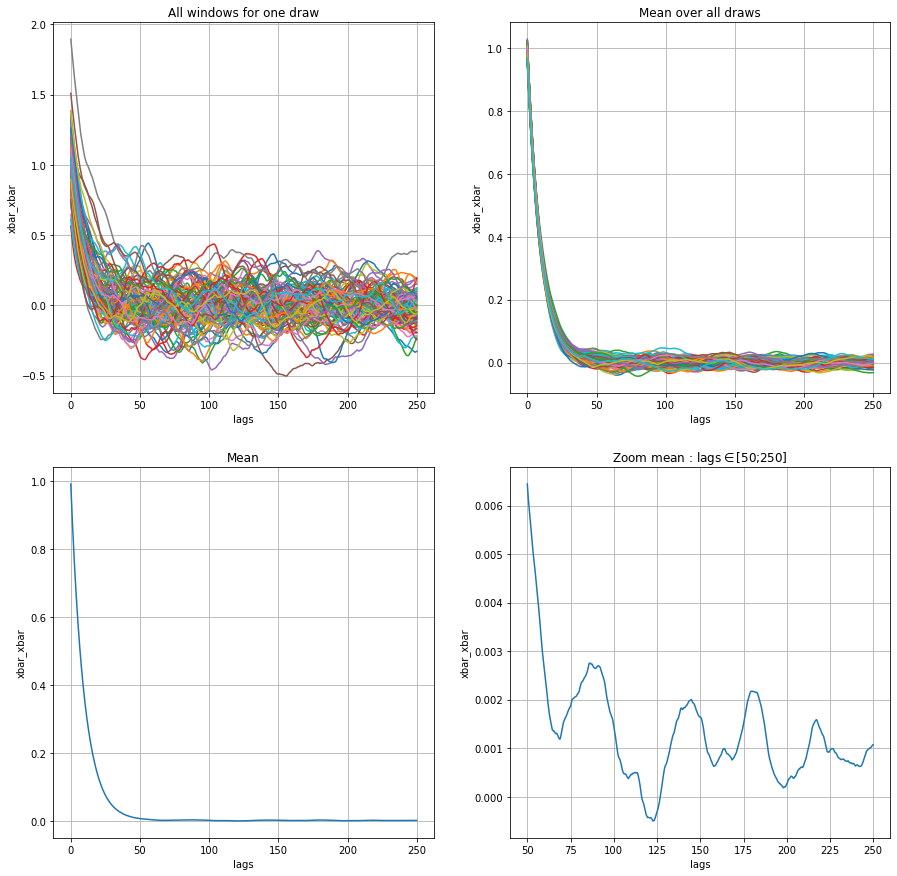

In [14]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xxbar.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xxbar.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xxbar.mean(['draw','windows']).plot(ax=ax[1,0])
xxbar.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid();ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

### Total signal : autocorrelation

In [19]:
xtotal.name = 'xtotal'
xx = ts.correlate(xtotal,xtotal,detrend=False).persist()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Zoom mean : lags$\\in$[50;250]')

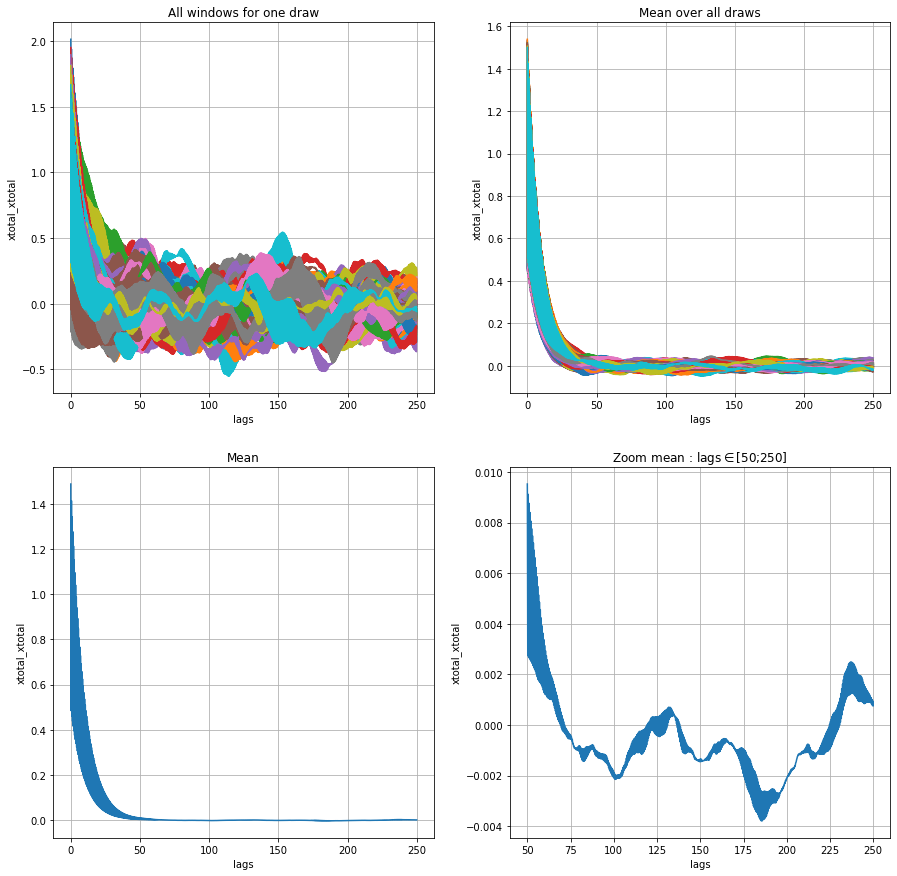

In [22]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
xx.isel(draw=10).plot.line(x='lags',ax=ax[0,0])
ax[0,0].legend().set_visible(False)
xx.mean('draw').plot.line(x='lags',ax=ax[0,1])
ax[0,1].legend().set_visible(False)
xx.mean(['draw','windows']).plot(ax=ax[1,0])
xx.mean(['draw','windows']).sel(lags=slice(50,250)).plot(ax=ax[1,1])
ax[0,0].grid();ax[1,0].grid();ax[0,1].grid();ax[1,1].grid()
ax[0,0].set_title('All windows for one draw');ax[1,0].set_title('Mean');ax[0,1].set_title('Mean over all draws')
ax[1,1].set_title(r'Zoom mean : lags$\in$[50;250]')

## Spectra

In [30]:
cluster.close()